In [1]:
import pandas as pd
import numpy as np
from math import ceil
import tensorflow as tf
from tensorflow.keras.layers import Input,ConvLSTM2D,BatchNormalization,Conv2D,Add
import keras_tuner as kt
import matplotlib.pyplot as plt


file_name = "./Abilene-OD_pair.txt"
df = pd.read_csv(file_name)
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data
timesteps=data.shape[0]
df['time']=df.index
times= df['time']
max_list = np.max(data, axis=0)
min_list = np.min(data, axis=0)
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0
data[np.isinf(data)] = 0
x_data = []
for i in range(timesteps ):
    x=data[i]
    x_data.append(x)

x_data = np.array(x_data)

x_data_2d=x_data.reshape((48096,12,12))
x_data_2d.shape

split_time=int(timesteps*0.8)
time_train = times[:split_time]
x_train = x_data_2d[:split_time]
time_valid = times[split_time:]
x_valid = x_data_2d[split_time:]
feature_count=[12,12]
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000
conv_input=[window_size,12,12]

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)




c:\Users\Mitri\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [20]:
model = tf.keras.models.load_model('./cnn-ltsm10.h5')

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.9,beta_2=0.999,epsilon=1e-07,)

model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer,metrics=["mse"])

history = model.fit(train_set, epochs=3) #callbacks=[lr_schedule]

Epoch 1/3
1203/1203 [==============================] - 694s 571ms/step - loss: 0.0085 - mse: 3.3399e-04
Epoch 2/3
1203/1203 [==============================] - 799s 665ms/step - loss: 0.0079 - mse: 3.1017e-04
Epoch 3/3
1203/1203 [==============================] - 896s 733ms/step - loss: 0.0077 - mse: 3.0115e-04


In [23]:
def model_forecast1(model, series, window_size, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [24]:


valforecast=model_forecast1(model, x_valid, window_size, batch_size)
x_valid_trimmed=x_valid[9:]
x_valid_trimmed.shape
x_valid_trimmed=x_valid_trimmed.reshape(9611,144)
x_valid_trimmed.shape
f1=valforecast.reshape((9611, 12, 12))
f1=f1.reshape(9611,144)
steps_valid=np.arange(0,x_valid_trimmed.shape[0],1)
steps_valid.shape




301/301 [==============================] - 113s 372ms/step


(9611,)

C:\Users\Mitri\AppData\Local\Temp\ipykernel_16440\238706105.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


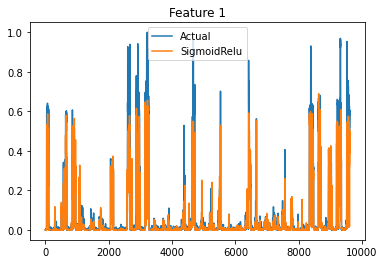

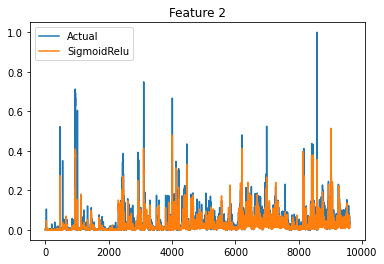

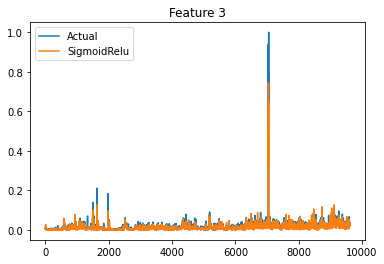

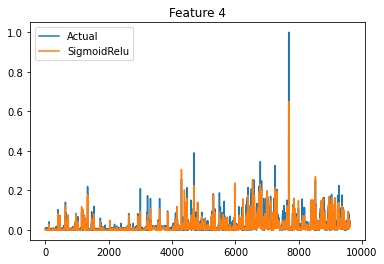

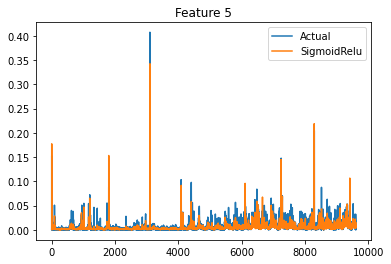

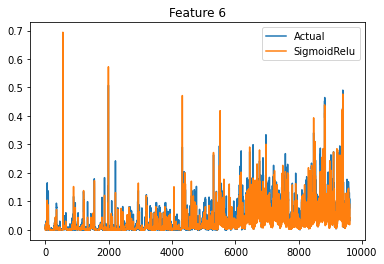

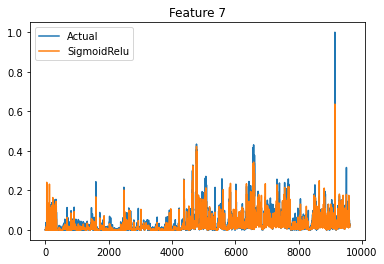

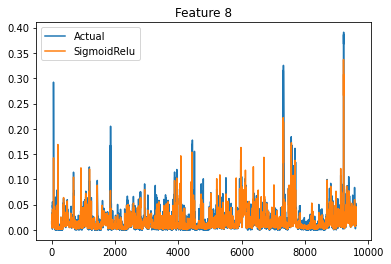

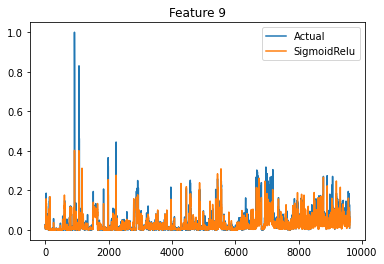

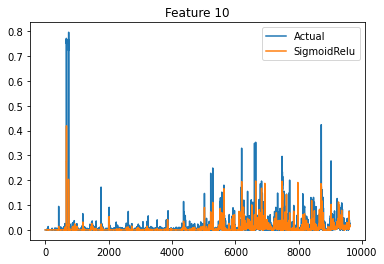

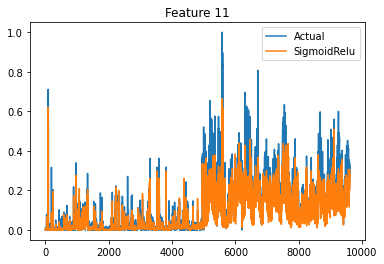

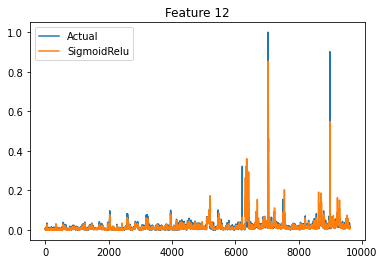

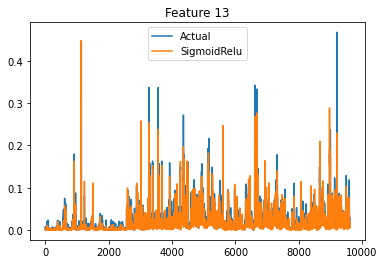

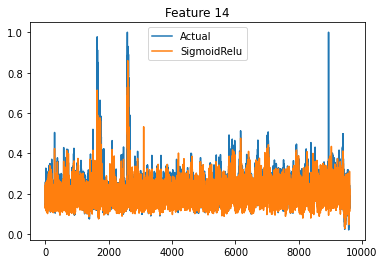

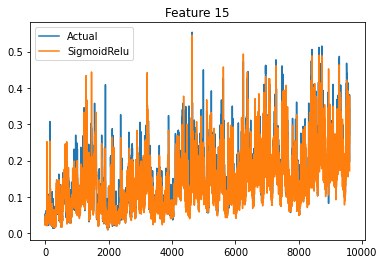

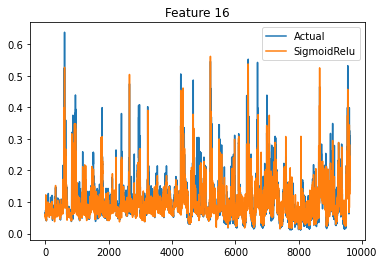

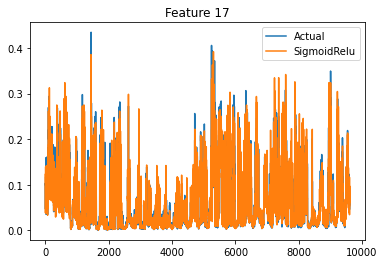

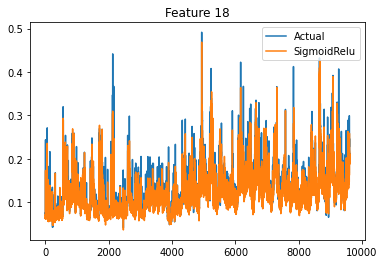

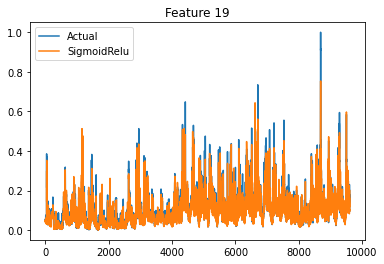

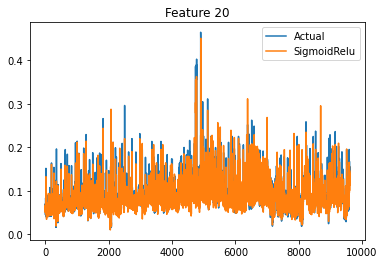

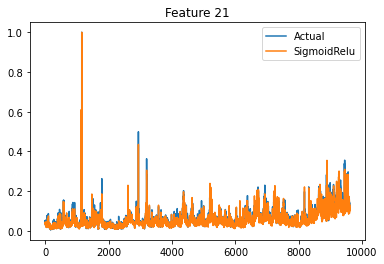

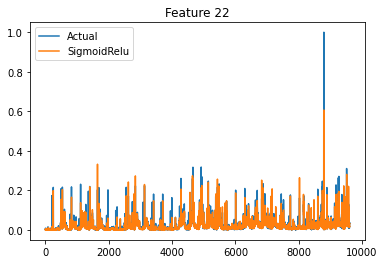

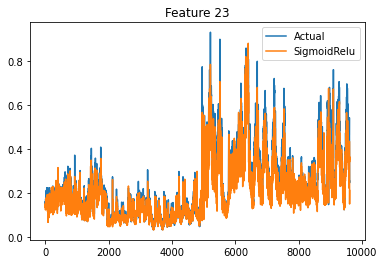

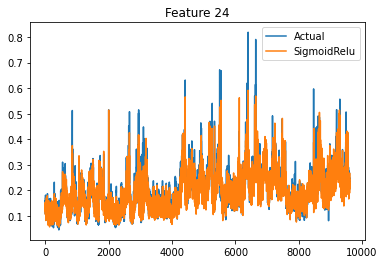

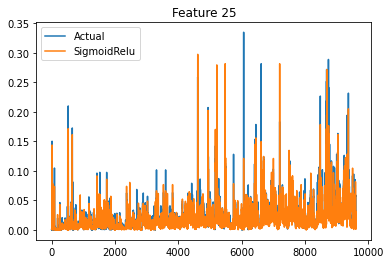

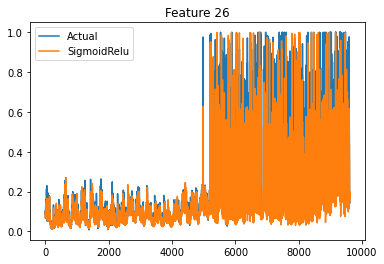

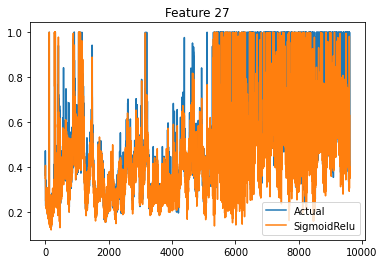

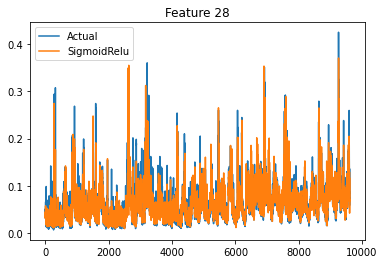

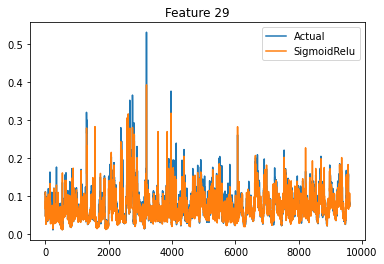

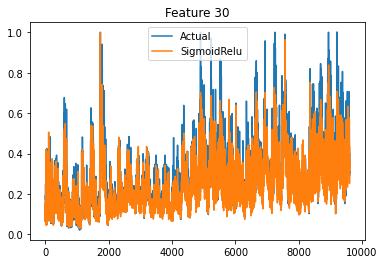

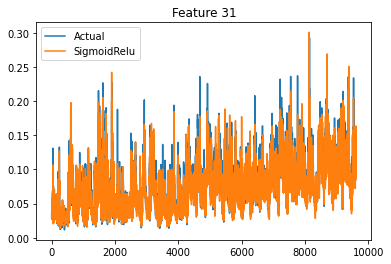

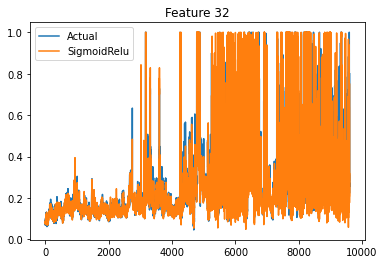

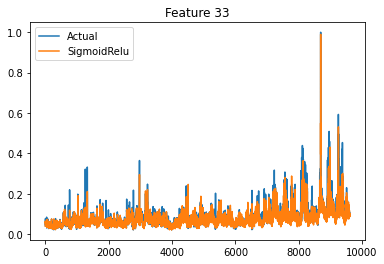

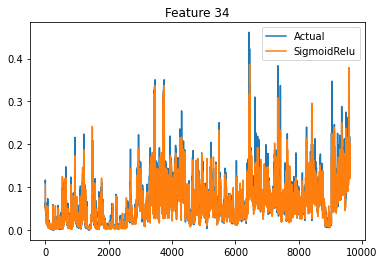

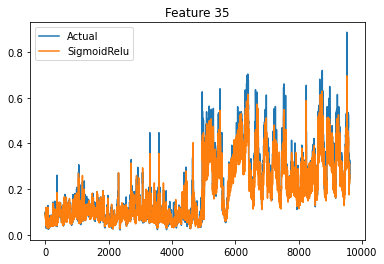

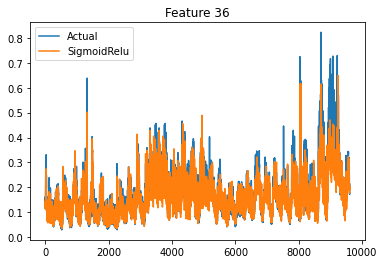

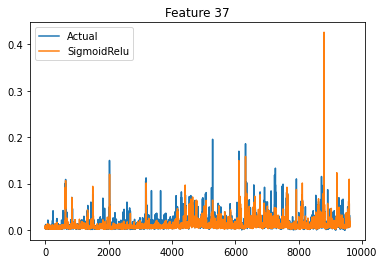

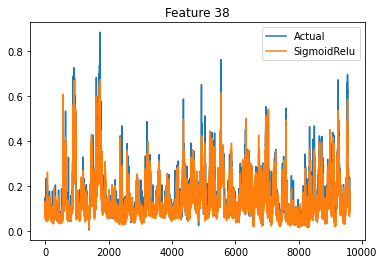

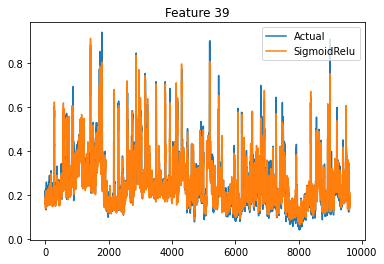

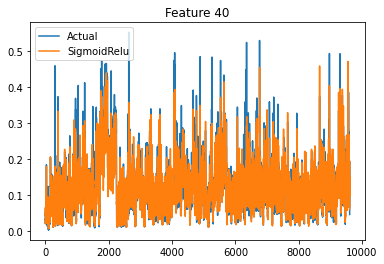

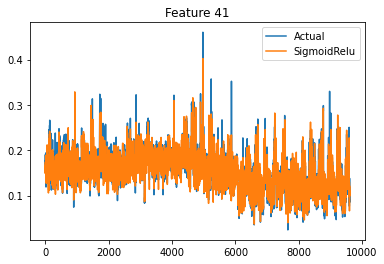

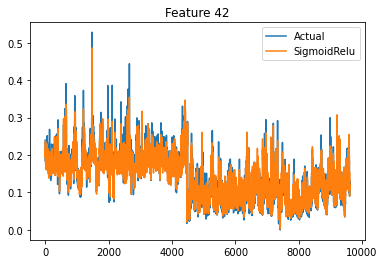

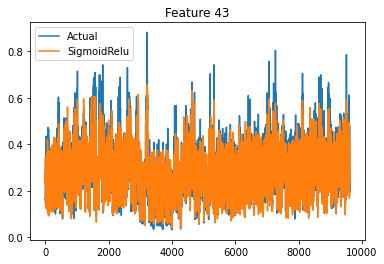

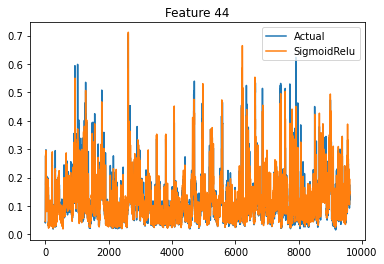

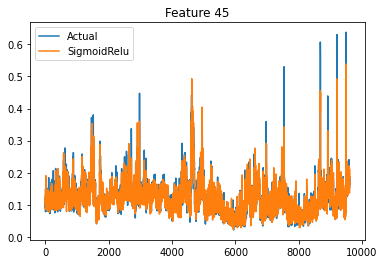

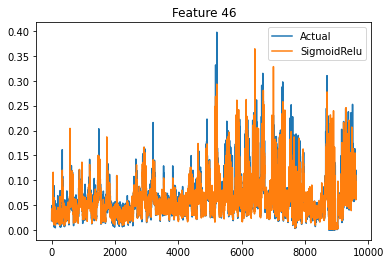

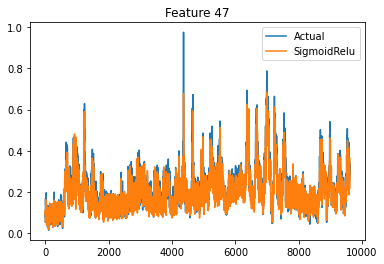

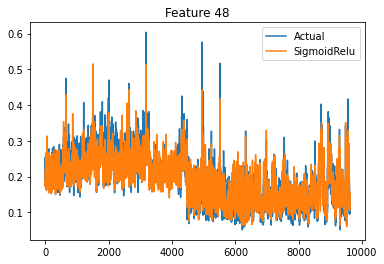

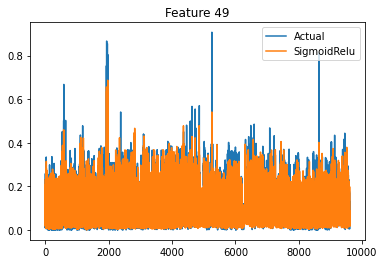

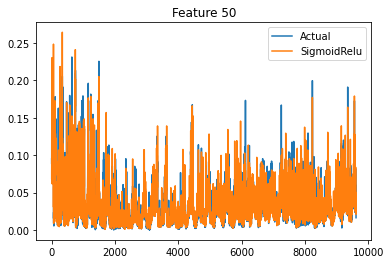

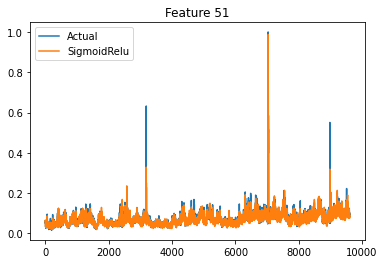

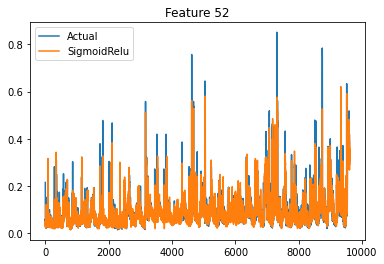

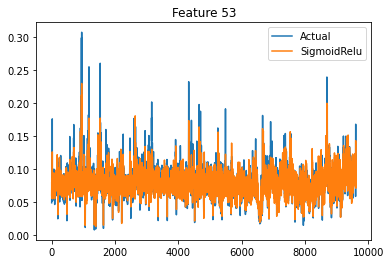

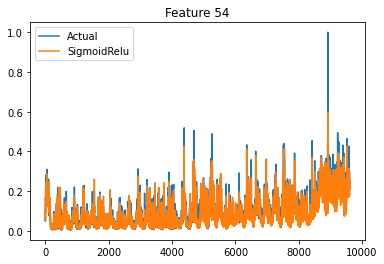

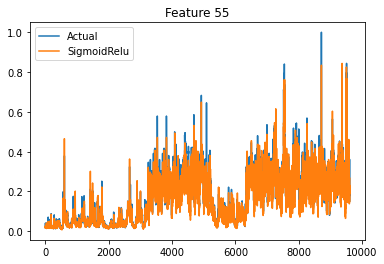

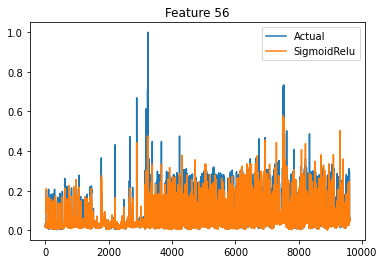

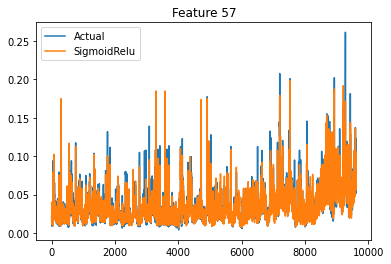

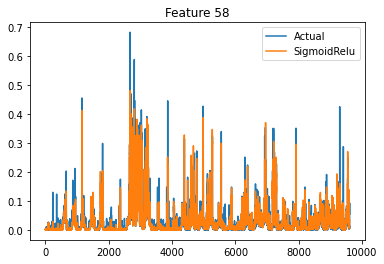

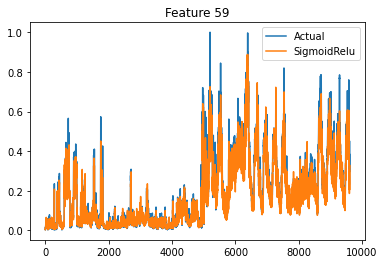

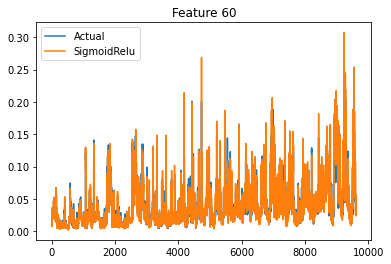

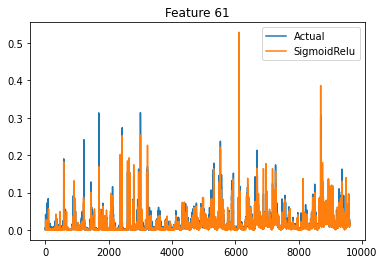

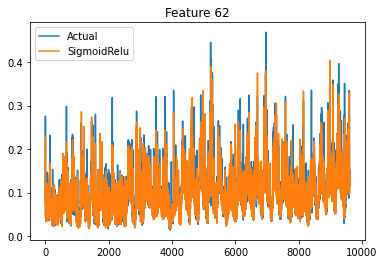

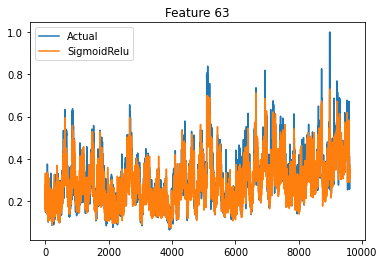

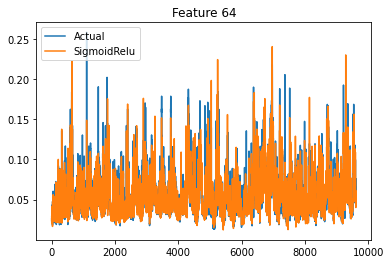

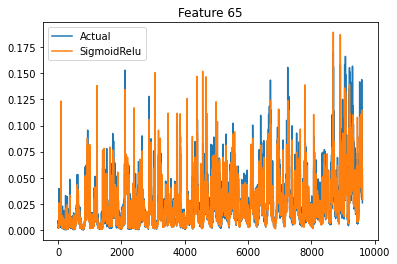

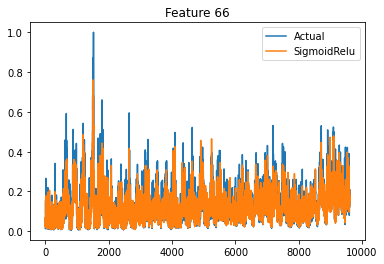

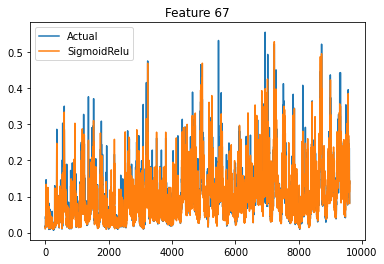

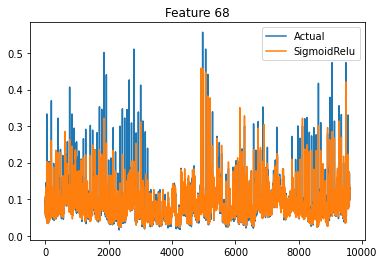

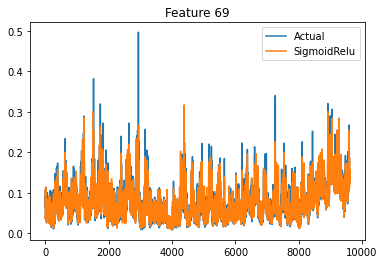

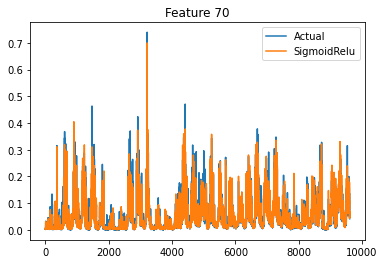

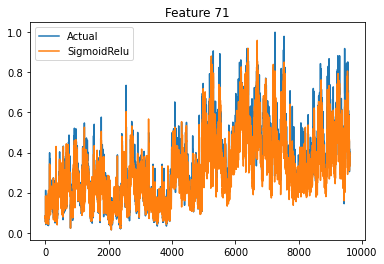

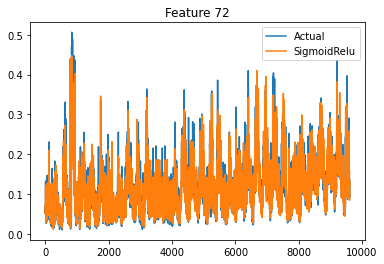

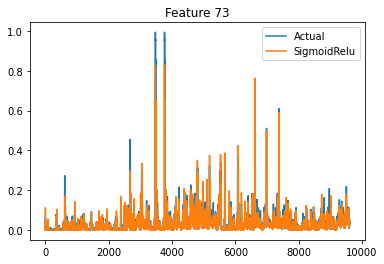

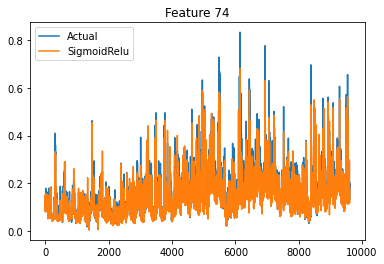

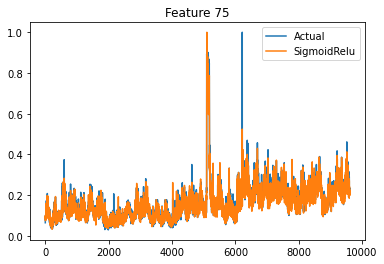

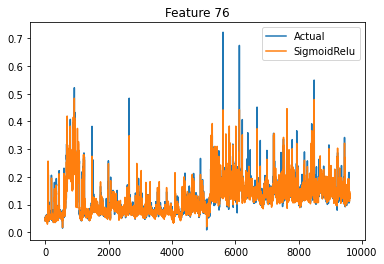

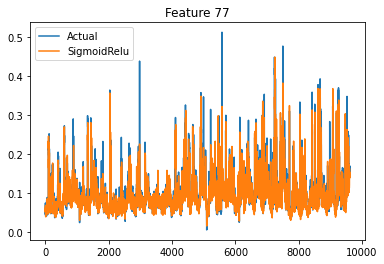

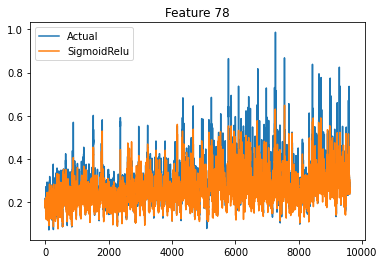

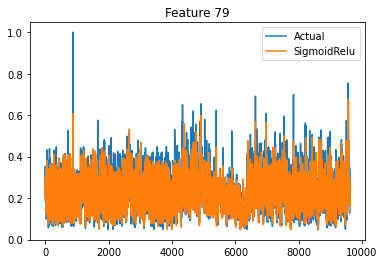

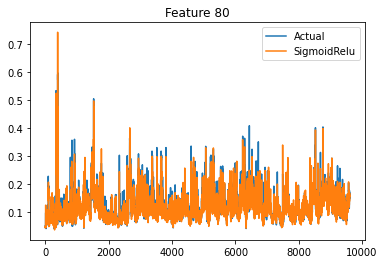

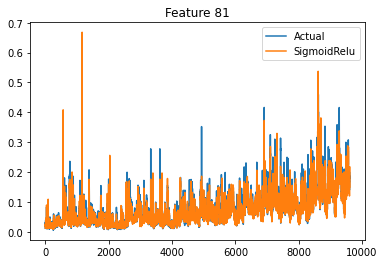

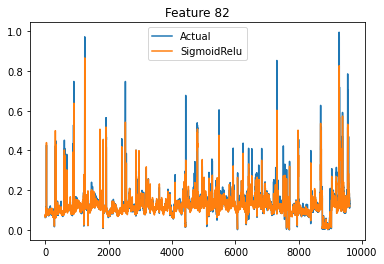

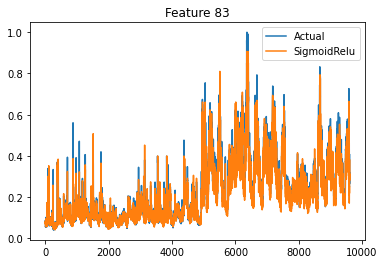

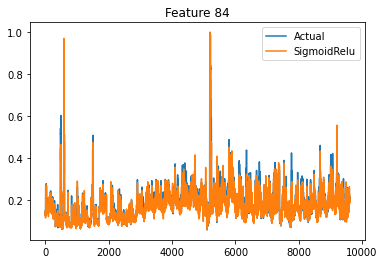

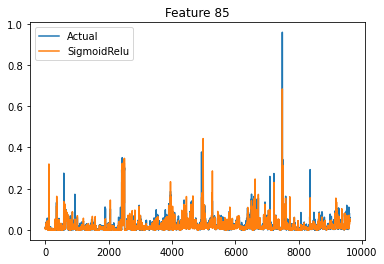

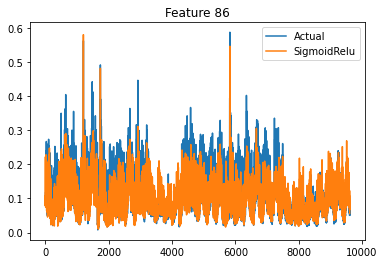

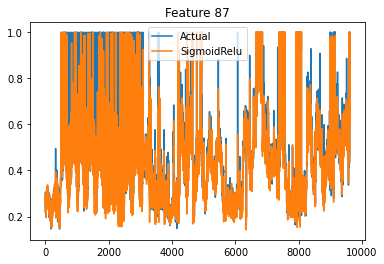

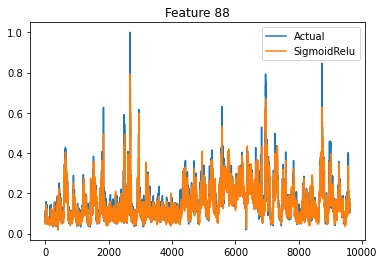

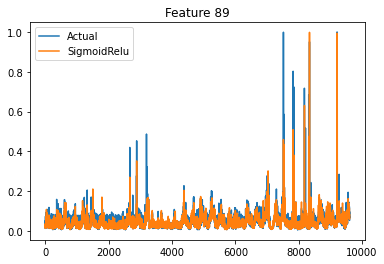

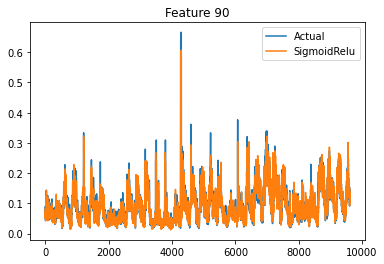

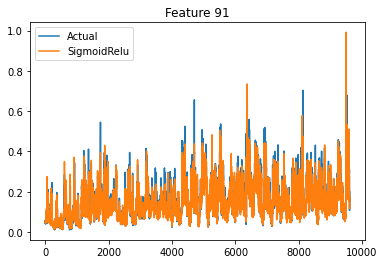

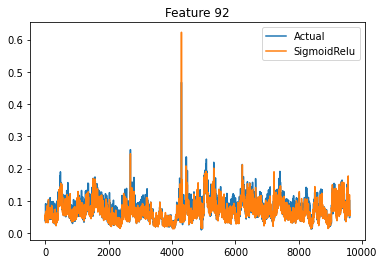

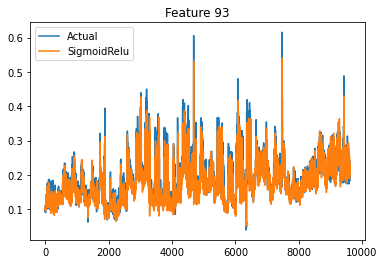

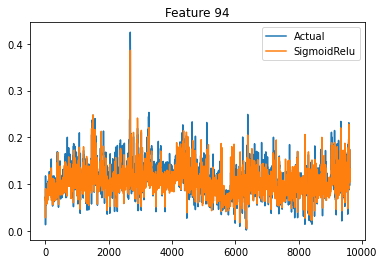

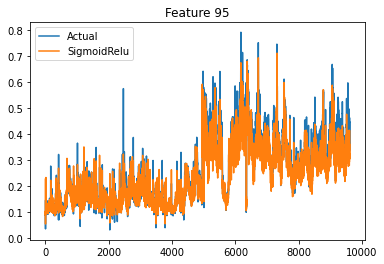

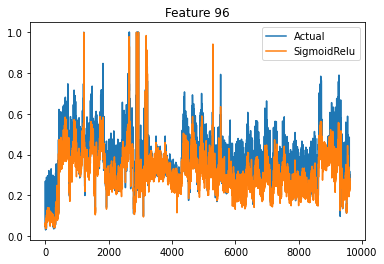

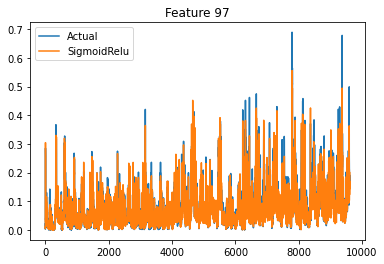

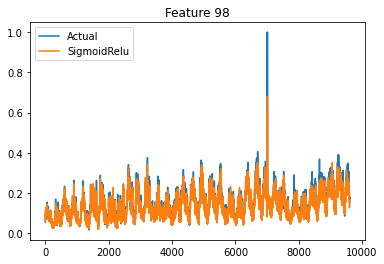

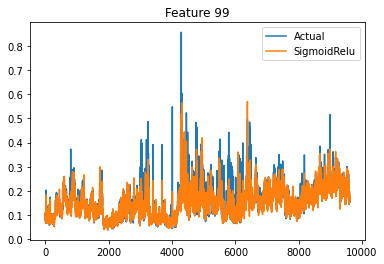

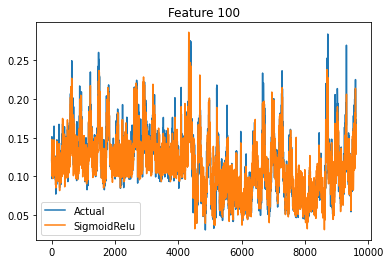

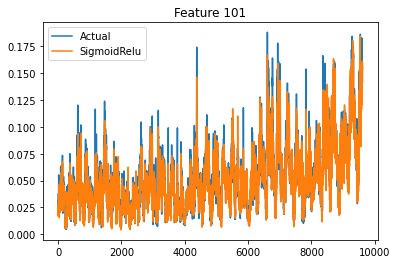

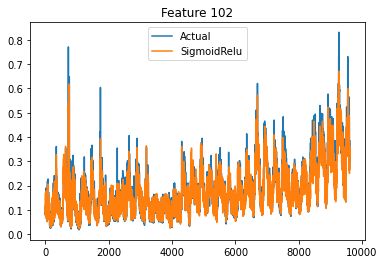

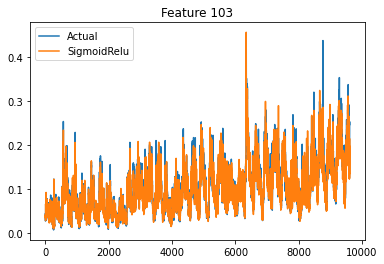

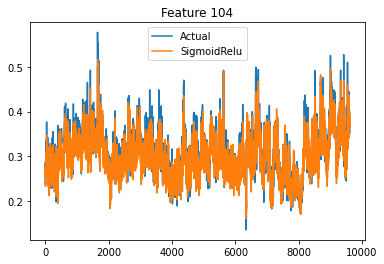

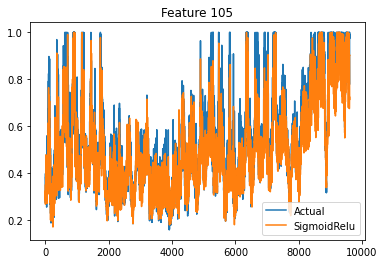

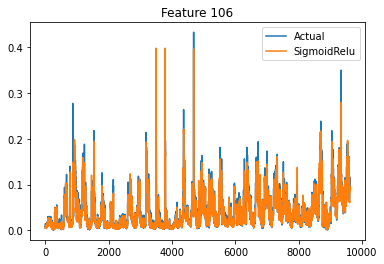

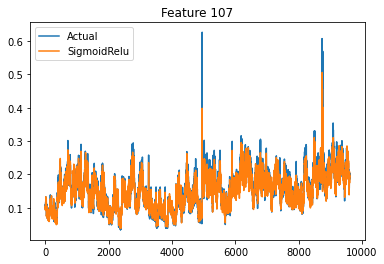

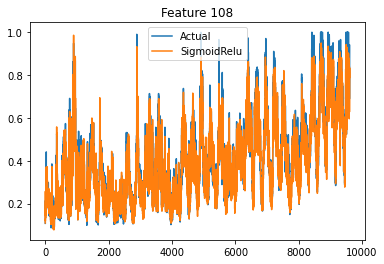

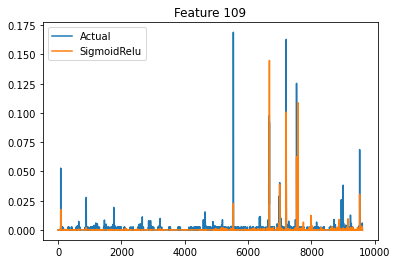

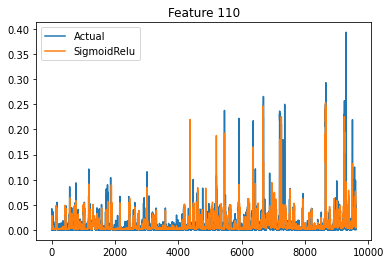

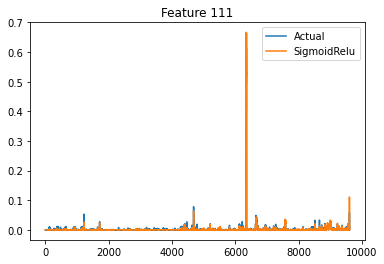

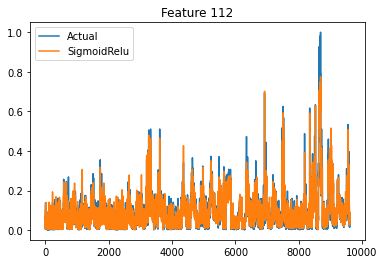

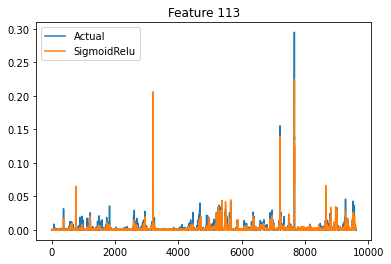

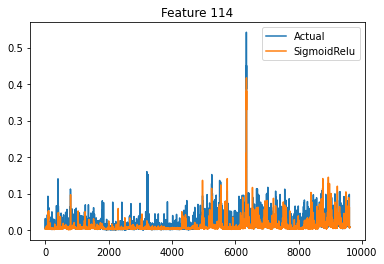

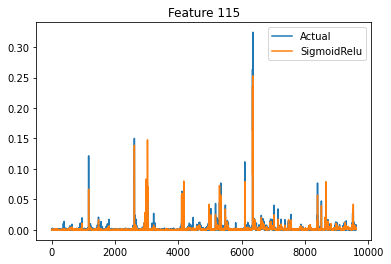

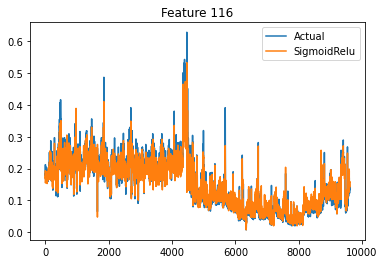

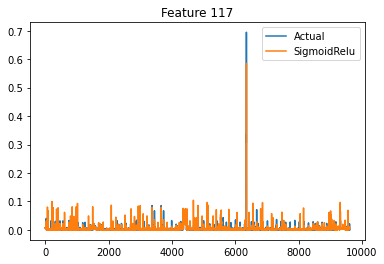

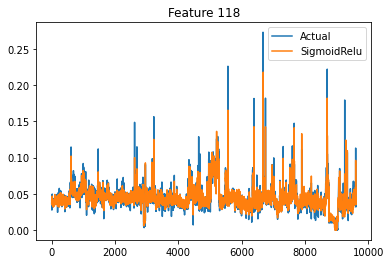

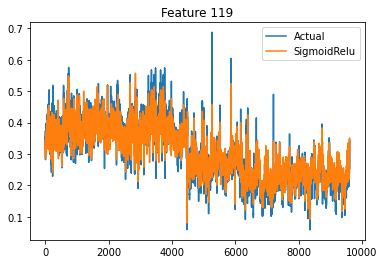

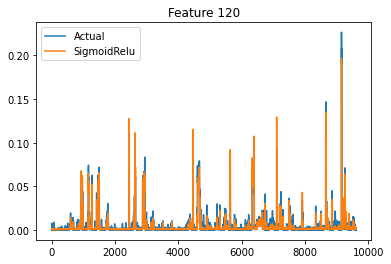

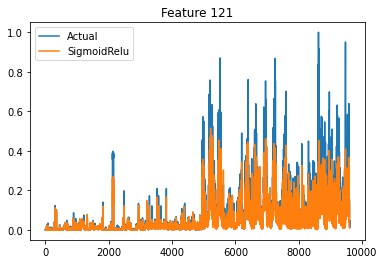

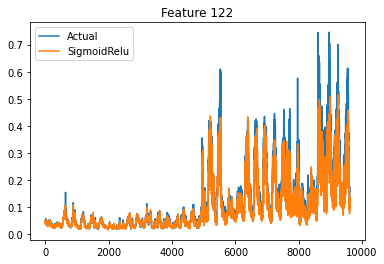

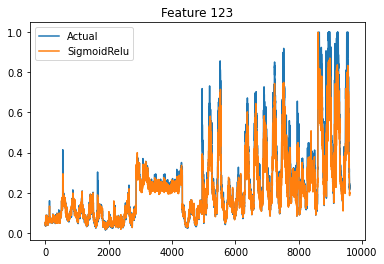

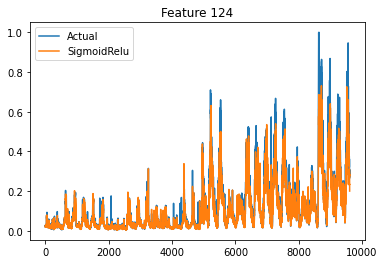

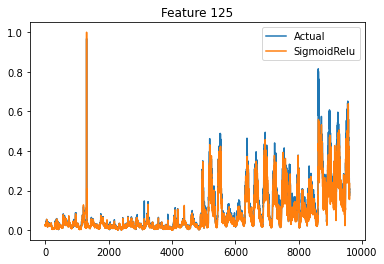

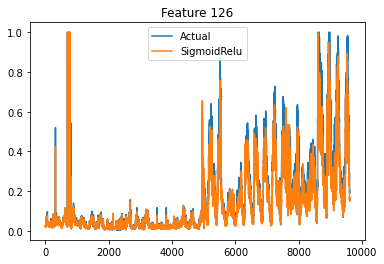

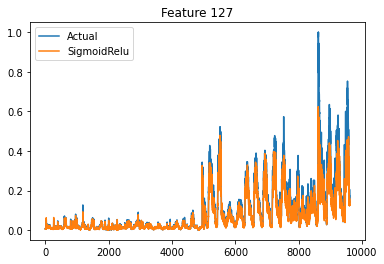

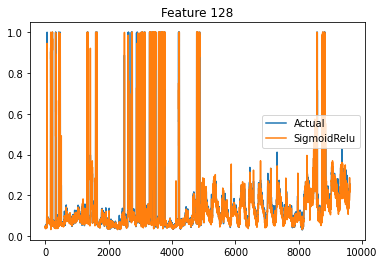

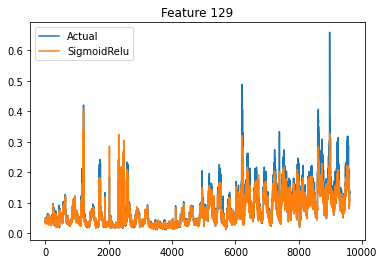

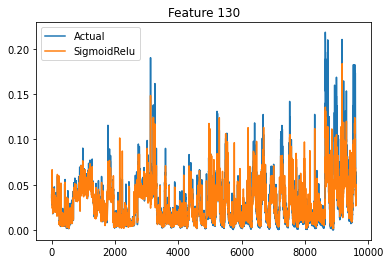

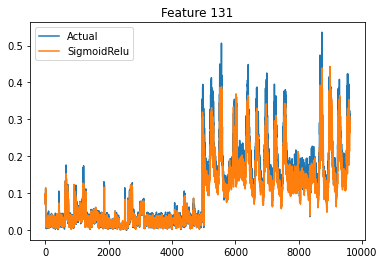

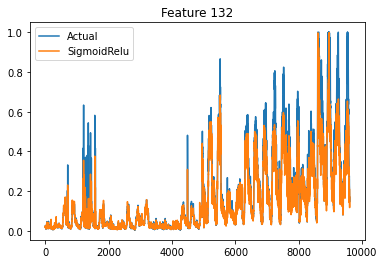

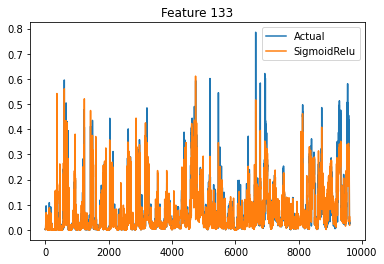

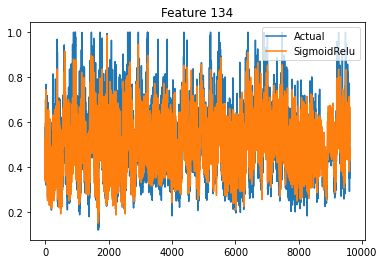

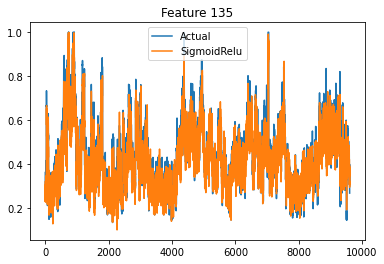

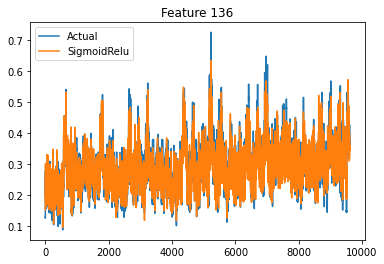

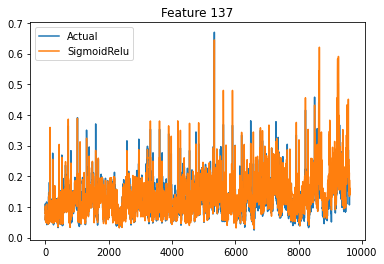

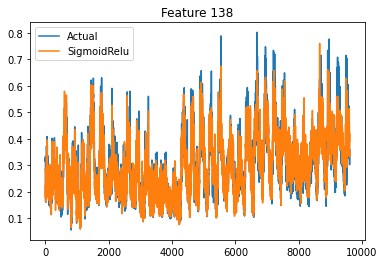

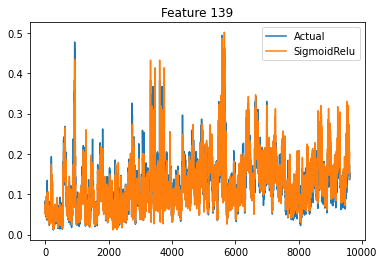

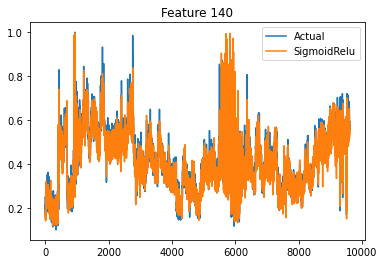

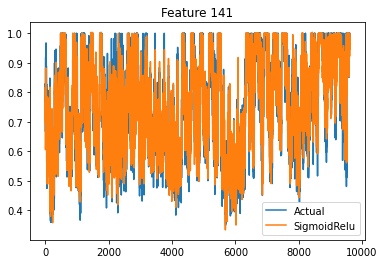

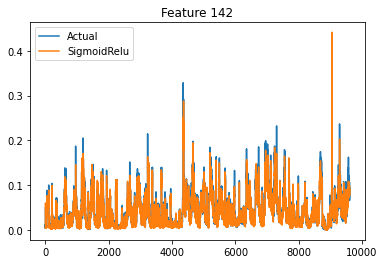

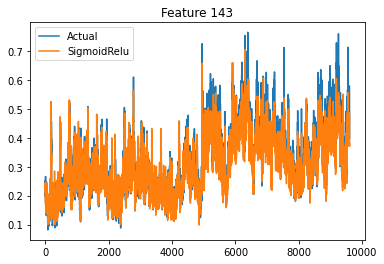

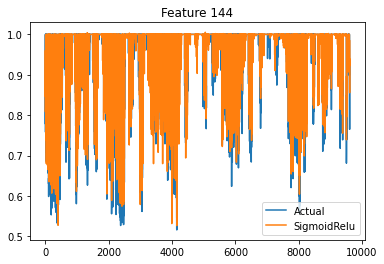

In [8]:
for i in range(144):
    plt.figure(i)
    plt.plot(steps_valid,x_valid_trimmed[:,i])
    plt.plot(steps_valid,f1[:,i])
    plt.legend(["Actual", "SigmoidRelu"])
    plt.title("Feature {}".format(i+1))

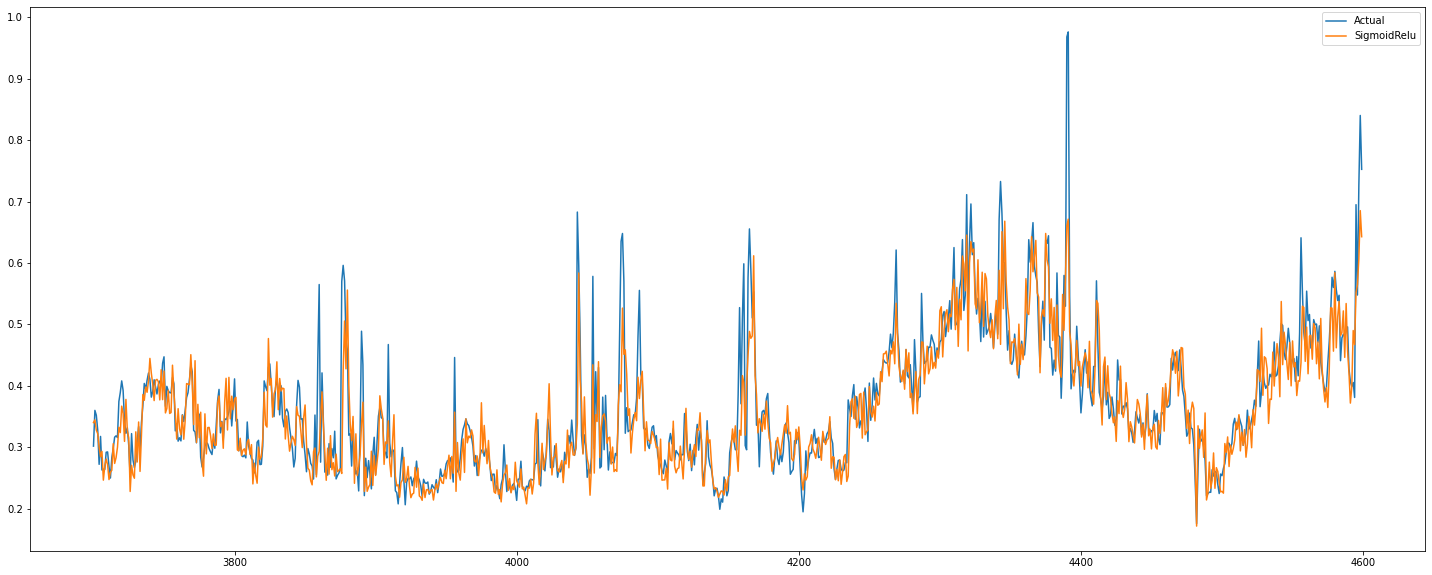

In [11]:
start_time=3700
end_time=4600
featurenum=26
plt.figure(figsize=(25,10))
plt.plot(steps_valid[start_time:end_time],x_valid_trimmed[start_time:end_time,featurenum])
plt.plot(steps_valid[start_time:end_time],f1[start_time:end_time,featurenum])
plt.legend(["Actual", "SigmoidRelu"])